# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

# Data Preperation

In [2]:
labels = ['Bird', 'Drone']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [3]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('BirdVsDrone','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('BirdVsDrone','val',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 22.87it/s]


## Visualize some of examples in training set

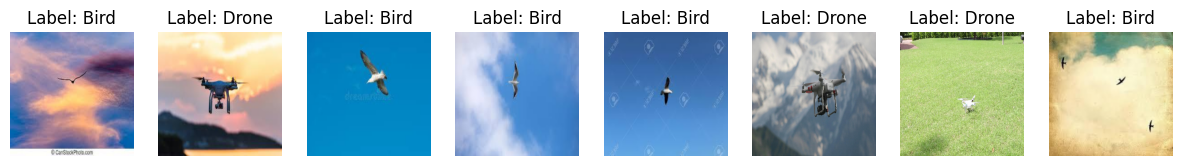

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define the number of images to display
num_images_to_display = 8

# Select random indices to display
random_indices = np.random.choice(range(X_train.shape[0]), num_images_to_display, replace=False)

# Create a grid of subplots
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for idx, random_index in enumerate(random_indices):
    # Get the image and its corresponding label
    sample_img = X_train[random_index]
    sample_label = y_train[random_index]
    
    # Convert the image from BGR (OpenCV format) to RGB (matplotlib format)
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    axs[idx].imshow(sample_img_rgb)
    axs[idx].set_title(f"Label: {sample_label}")
    axs[idx].axis('off')

plt.show()


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)

In [6]:
X_train.shape

(825, 224, 224, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)

**One Hot Encoding**

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
y_train.shape

(742, 2)

# Transfer Learning

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pre-trained weights, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)  # Flatten the output from the convolutional layers
x = Dense(256, activation='relu')(x)  # Add a fully connected layer with 256 units and ReLU activation
x = Dropout(0.5)(x)  # Add dropout for regularization
x=  Dense (128, activation='relu')(x)
x=  Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)  # Add a fully connected layer with a single unit for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,170,626 (80.76 MB)

 Trainable params: 6,455,938 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Training The Model

In [11]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=32)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 372s 18s/step - accuracy: 0.6510 - loss: 3.8905 - val_accuracy: 0.9200 - val_loss: 0.3376
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 415s 20s/step - accuracy: 0.9046 - loss: 0.6144 - val_accuracy: 0.9867 - val_loss: 0.0323
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 544s 25s/step - accuracy: 0.9393 - loss: 0.2937 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 467s 22s/step - accuracy: 0.9407 - loss: 0.4220 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 469s 22s/step - accuracy: 0.9682 - loss: 0.2711 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 420s 20s/step - accuracy: 0.9716 - loss: 0.1713 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 321s 15s/step - accuracy: 0.9804 - loss: 0.0617 - val_accuracy: 0.9867 - val_loss: 0.0269
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 317s 15s/step - accuracy: 0.9816 - loss: 0.0727 - val_accuracy: 0.

# Evaluate the model

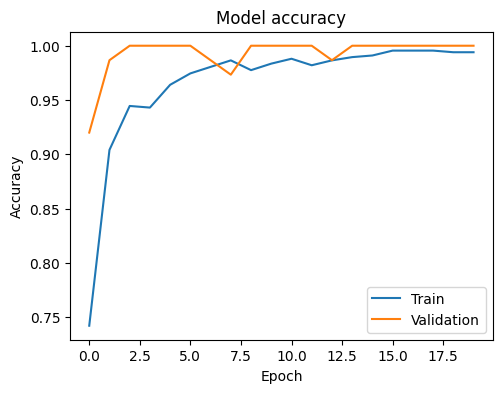

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

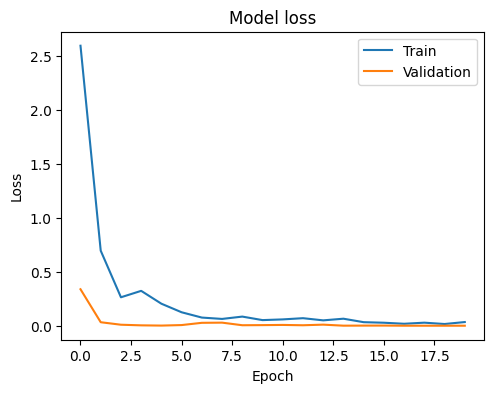

In [13]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [14]:
y_pred = model.predict(X_test)
 
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 11s/step


In [15]:
y_test.shape

(83, 2)

In [16]:
y_pred.shape

(83, 2)

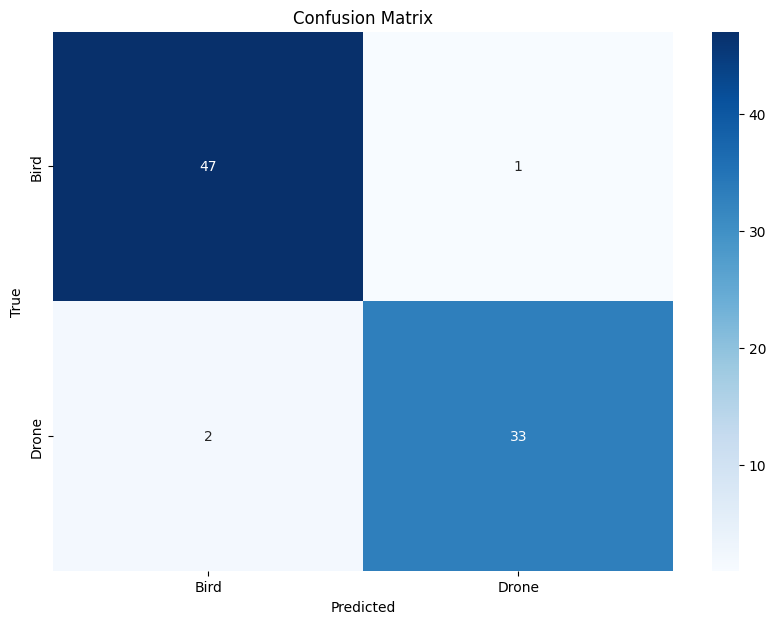

In [17]:
import matplotlib.pyplot as plt

# class_names = ['ajrak', 'balochi', 'kalash', 'shalwarKameez']
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred_classes are defined somewhere in your code
cnf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
from sklearn.metrics import classification_report

cr = classification_report(y_true, y_pred_classes, target_names=labels)
print(cr)

              precision    recall  f1-score   support

        Bird       0.96      0.98      0.97        48
       Drone       0.97      0.94      0.96        35

    accuracy                           0.96        83
   macro avg       0.96      0.96      0.96        83
weighted avg       0.96      0.96      0.96        83



#### Achieved Significant accuracy of 97% to classify BirdsvsDrones.

## Save the model

In [19]:
model.save('my_model.h5')


In [20]:
import keras
keras.saving.save_model(model, 'my_model.keras')

## Lets test any random image across the internet

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load your trained model (assuming 'model' is already trained)
# model = tf.keras.models.load_model('path_to_your_model.h5')

# Load and preprocess a new image
img_path = 'drone.jpeg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = x / 255.0  # Normalize pixel values

# Make prediction
predictions = model.predict(x)

# Assuming binary classification, get the predicted class label (0 or 1)
predicted_class = np.argmax(predictions, axis=1)[0]

# Define class names
class_names = ['Bird', 'Drone']  # Replace with your actual class names

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

# Get the predicted probabilities for each class (if needed)
class_probabilities = predictions[0]

# Print results
print(f"Predicted class: {predicted_class_name}")
print(f"Class probabilities: {class_probabilities}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Drone
Class probabilities: [1.3995364e-20 1.0000000e+00]


### Model is able to correctly classify random images from the internet. 